# Financial Time Series Analysis: Programming Tutorial [PART I]

Course material for CMU 46-929, Spring 2023 (Instructor: Arun Kumar Kuchibhotla).

Written & presented by YJ Choe ([yjchoe@cmu.edu](mailto:yjchoe@cmu.edu)).

---

In this tutorial, we will go over the basics of time series modeling, focusing on actual Python code snippets.


### Part I: Diagnostics, Trend Fitting, and Seasonal Decomposition
- [Data and Basic Diagnostics](#Data-and-Basic-Diagnostics)
- [Seasonal Decomposition](#Seasonal-Decomposition)
- [Basic Trend Fitting Methods](#Basic-Trend-Fitting-Methods)
- [Tests for White Noise (Bartlett, Ljung-Box, and Box-Pierce)](#Tests-for-White-Noise)

### Part II: Model-Free Nonparametric Prediction Methods

See notebook [`Tutorial-02-ModelFreePrediction.ipynb`](Tutorial-02-ModelFreePrediction.ipynb).

### Part III: The ARMA Family of Models: $\mathrm{MA}(q)$, $\mathrm{AR}(p)$, and $\mathrm{ARMA}(p, q)$

See notebook [`Tutorial-03-ARIMA.ipynb`](Tutorial-03-ARIMA.ipynb).


---

## *Before We Begin: Best Programming Practices

Generally helpful guides:
- [PEP 8 — the Style Guide for Python Code](https://pep8.org/)
- [Google's Python style guide](https:/google.github.io/styleguide/pyguide.html)
- [How to Write High-Quality Python as a Data Scientist](https://towardsdatascience.com/how-to-write-high-quality-python-as-a-data-scientist-cde99f582675)
- [Vectorization in NumPy (and why it matters)](https://realpython.com/numpy-array-programming/)

Specific advices based on previous homework submissions:
- [Don't Repeat Yourself (DRY)](https://www.earthdatascience.org/courses/intro-to-earth-data-science/write-efficient-python-code/intro-to-clean-code/dry-modular-code/): Think before copy-and-pasting code from a previous problem. Can I make it into a function and just call it again?
- **Limit each line of the code to 80 (recommended) or 120 characters.**
- For a Jupyter notebook, make sure you `Restart & Run All` to make sure all parts of the code run without an error.
- When exporting a Jupyter notebook into a PDF, use either:
    - Jupyter notebook: `File -> Download as -> PDF via LaTeX (pdf)`.
    - Jupyterlab: `File -> Save and Export Notebook as -> PDF`.
    - Otherwise, your code (especially ones that have long lines) will not be printed out properly!

---

## Setup

We will mostly be using `statsmodels`, along with `numpy` and `pandas`.

The following imports illustrate the canonical ways of using the [`statsmodels` API](https://www.statsmodels.org/devel/api.html).
If a method is not in the API, we can always import it manually (`from ... import ...`).

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as tsa

import warnings
warnings.filterwarnings("ignore")  # not advised for general purposes

In [243]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [244]:
# set styles globally for matplotlib and seaborn
FIGSIZE = (12, 4)
PLOT_STYLE = "seaborn-v0_8-colorblind"

plt.style.use(PLOT_STYLE)
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.5,
)

Next, we define basic data retrieval and plotting functions (from HW1).

In [245]:
def read_ts_data(csv_filename, time_column,
                 start=None, end=None, sort_index=True):
    """Read a time series dataset in a csv file
    (e.g., from the Wall Street Journal page)."""
    df = pd.read_csv(csv_filename).set_index(time_column)
    # set index to a datetime
    df.index = pd.to_datetime(df.index)
    # strip columns of whitespaces
    df.columns = [col.strip() for col in df.columns]
    if start is not None:
        df = df[df.index >= start]
    if end is not None:
        df = df[df.index <= end]
    return df.sort_index() if sort_index else df


def tsplot(
        y,
        title="",
        lags=None,
        figsize=(FIGSIZE[0], 2 * FIGSIZE[1]),
        style=PLOT_STYLE,
):
    """Plot a time series with a QQ-plot and an autocorrelation plot."""
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (1, 0))
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        tsa.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.qqplot(y, line="s", ax=qq_ax)
        qq_ax.set_title("Normal QQ-plot")
        fig.tight_layout()
    return fig


def compute_returns(
        y,
        symbol,
        period=1,
        use_relative=False,
        use_log=True,
        plot=False,
        **plot_kwargs,
) -> pd.Series:
    """Compute the (relative) (log-)returns of a time series."""
    assert not (use_relative and use_log), \
        "can only compute either relative or log returns"
    if use_relative:
        returns = (y.diff(period) / y.shift(period)).dropna()
        name = "RelativeReturns"
    else:
        returns = (y / y.shift(period)).dropna()
        name = "Returns"
        if use_log:
            returns = np.log(returns)
            name = "LogReturns"

    returns = returns[::period]
    returns.rename(name, inplace=True)

    if plot:
        days_str = f"{period}-day" if period > 1 else "Daily"
        tsplot(
            returns,
            title=f"{days_str} {name}: {symbol}",
            **plot_kwargs,
        )
    return returns


def get_airline_passengers(
        start,
        end,
        use_log=False,
        plot=False,
        url="https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv",
        **plot_kwargs,
) -> pd.Series:
    """Retrieve and (optionally) plot the monthly airline passengers dataset."""
    passengers = pd.read_csv(url).set_index("Month")
    # get DatetimeIndex(freq="MS")
    passengers.index = \
        pd.to_datetime(passengers.index).to_period().to_timestamp()
    passengers = passengers.loc[start:end, "Passengers"]
    if use_log:
        passengers = np.log(passengers)
    if plot:
        log_str = "Log of " if use_log else ""
        tsplot(
            passengers,
            log_str + "Number of monthly airline passengers (thousands)",
            **plot_kwargs,
        )
    return passengers

---
# Part I: Diagnostics, Seasonal Decomposition, and Trend Fitting

## Data and Basic Diagnostics

For most of this notebook, we will use two kinds of datasets:
- `prices`, `log_returns`, `log_returns_5day`: Prices and log-returns (1-/5-day) of a stock. Downloaded from the [Wall Street Journal market data](https://www.wsj.com/market-data/quotes/AAPL/historical-prices).
- `passengers`: Monthly number of airline passengers (in thousands), originally used by Box and Jenkins in 1976 (downloaded from, e.g., [here](https://github.com/jbrownlee/Datasets/blob/master/airline-passengers.csv)). _This time series is known to include a clear seasonal (yearly) pattern._

In [246]:
START_DATE = "2019-03-14"
END_DATE = "2022-12-14"

SYMBOL = "AAPL"

In [247]:
prices = read_ts_data(
    f"data/{SYMBOL}_WSJ_HistoricalPrices.csv",
    "Date",
    start=START_DATE,
    end=END_DATE,
)["Close"]
prices.name = SYMBOL

First, the stock prices show a clear trend and not-as-clear seasonality.
Also note that the volatility appears to change over time.

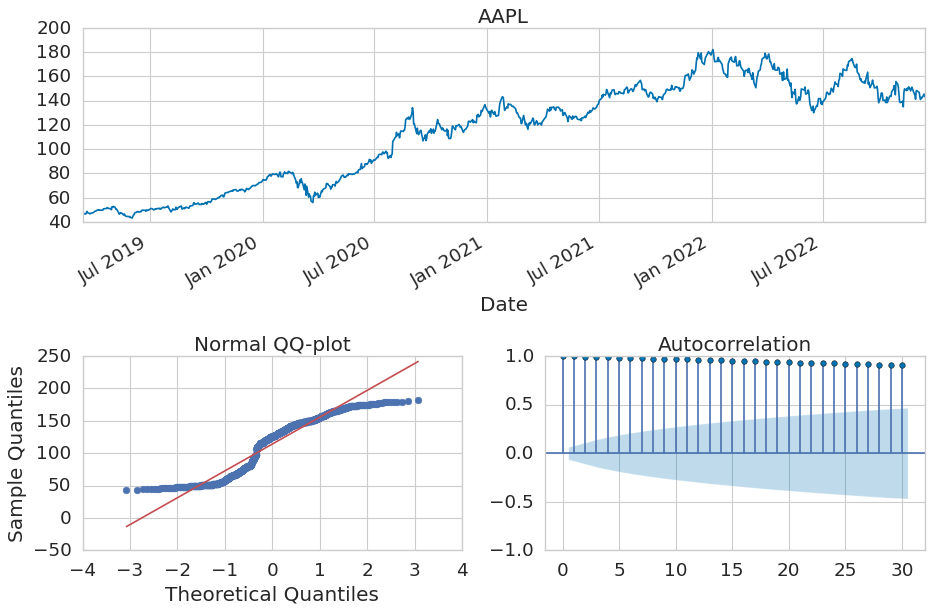

In [248]:
fig = tsplot(prices, title=SYMBOL)

One useful transformation to the price process is to take either relative or log returns of the prices.

- Relative returns: $(X_t - X_{t-1})/X_{t-1}$.
- Log-returns: $\log (X_t / X_{t-1})$.

Since relative returns are covered in HW, here we use the log-returns.
First, when looking at the daily log-returns, we observe no clear seasonality but some volatility clustering (will be covered in class soon). In terms of the noise process, we see some heavy-tailed noise and autocorrelations at lags 1, 6, 7, 8, 9, and so on.

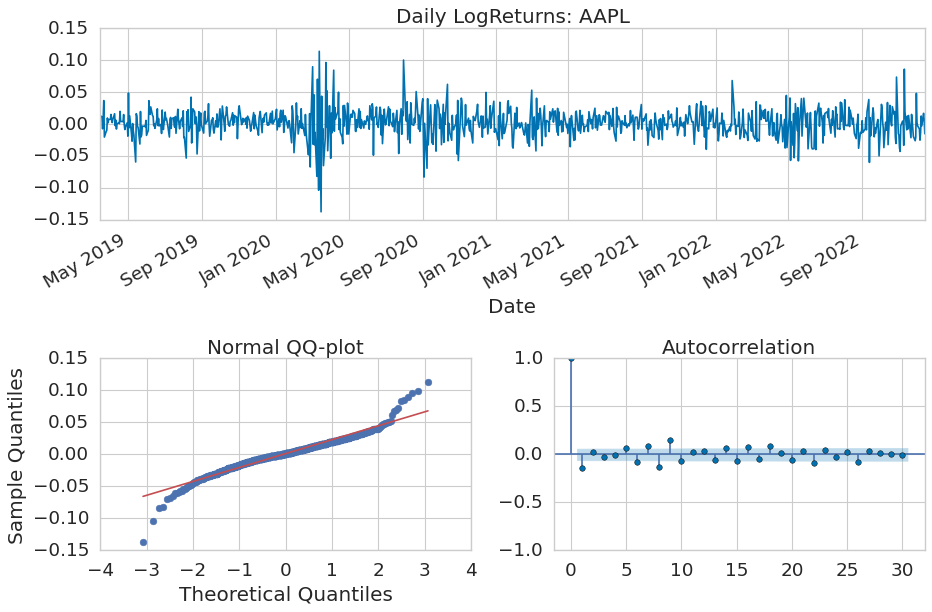

In [249]:
log_returns = compute_returns(
    prices,
    SYMBOL,
    period=1,
    use_log=True,
    plot=True,
)

We can also try computing the log-returns with a lower frequency.
For the "weekly" (roughly 5 business days) log-returns, we still observe some heavy-tailed noise, but the autocorrelations become non-significant.

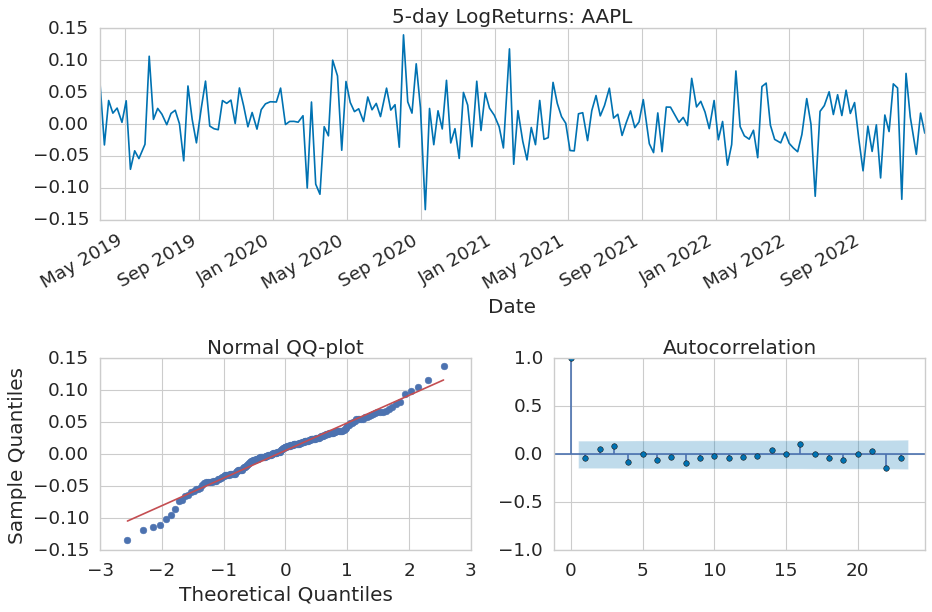

In [250]:
log_returns_5day = compute_returns(
    prices,
    SYMBOL,
    period=5,
    use_log=True,
    plot=True
)

In the canonical airline passengers dataset, we do observe a clearly increasing trend and also a clear seasonal behavior.
The tail of the noise is light on the left and slightly heavy on the right; the autocorrelation appears significant up to 14 lags.

There are two important things to note about the seasonality of this time series:
1. The autocorrelations exhibit a clear seasonal trend: the ACs reach peaks at lags 12 and 24.
   This suggests using a **seasonal decomposition at period 12** (i.e., yearly).
2. Looking at the time series itself, we see that the seasonal fluctuations increase/decrease proportionally with the magnitude of the time series itself.
   This suggests that a **multiplicative decomposition** of the time series can be suitable.

In [251]:
# training data for passengers
PASSENGERS_START = "1949-01-01"
PASSENGERS_END = "1959-12-01"

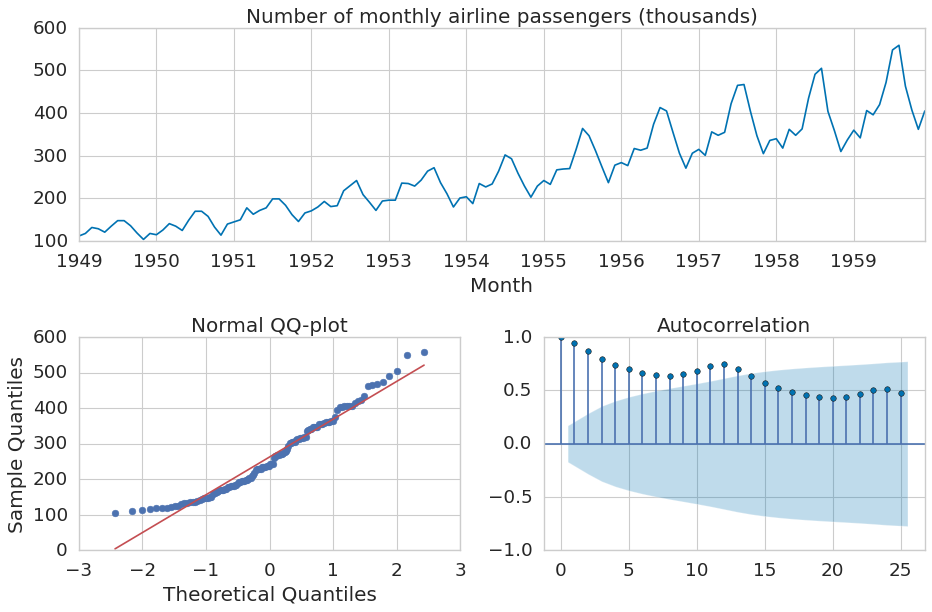

In [252]:
passengers = get_airline_passengers(PASSENGERS_START, PASSENGERS_END,
                                    use_log=False, plot=True, lags=25)
log_passengers = pd.Series(np.log(passengers), name="LogPassengers")

## Seasonal Decomposition

Sometimes, we may suspect from the data that there is a (deterministic) seasonality component in the time series, as illustrated in the airline passengers data.

Recall that a time series can be decomposed into trend, seasonality, and noise, either multiplicatively or additively.
- **Additive decomposition**:
    $$
    X_t = T_t + S_t + N_t.
    $$
- **Multiplicative decomposition**:
    $$
    X_t = T_t * S_t * N_t.
    $$

These decomposition methods can be generic & useful tools for modeling and visualizing the time series.
As shown in class, a multiplicative decomposition can be more reasonable when the seasonal fluctuations vary with the magnitude of the time series itself,
while an additive decomposition can handle negative values (e.g., relative or log returns).

_For the purposes of modeling the residuals using stationary models (e.g., using ARMA models),
whether or not a decomposition is reasonable can be verified using a statistical test of stationarity (e.g., Dickey-Fuller) on the residuals._

Note that, if $X_t$ has a multiplicative decomposition, then its logarithm has an additive decomposition via:
$$
\log X_t = \tau_t + \sigma_t + \nu_t,
$$
where $\tau_t = \log T_t$, $\sigma_t = \log S_t$, and $\nu_t = \log N_t$.

In `statsmodels`, there is a simple way to view this decomposition with a suspected period of seasonality via `tsa.seasonal_decompose()`.
Under the hood, the trend is fit using a [convolutional filtering](https://www.statsmodels.org/dev/generated/statsmodels.tsa.filters.filtertools.convolution_filter.html) approach and the seasonality is simply the seasonal average of the detrended time series with a specified period.
Since the seasonality in the passengers data appear to be yearly, we choose `period=12` (months).

**A general recipe for understanding the decomposition plots is to look at whether the residuals (fourth plot) appear stationary or white noise over time. If not, additional transformations (or more flexible models) might be necessary.**

Note that this is still a diagnostic tool --- we will be using formal tests of stationarity when fitting and checking our models (later).

### Passengers

The classical airline passengers dataset is an example of a time series that exhibits a clear seasonality.
The seasonal patterns also appear to vary with the number of passengers itself, so a multiplicative decomposition is more useful than an additive decomposition (as shown below).

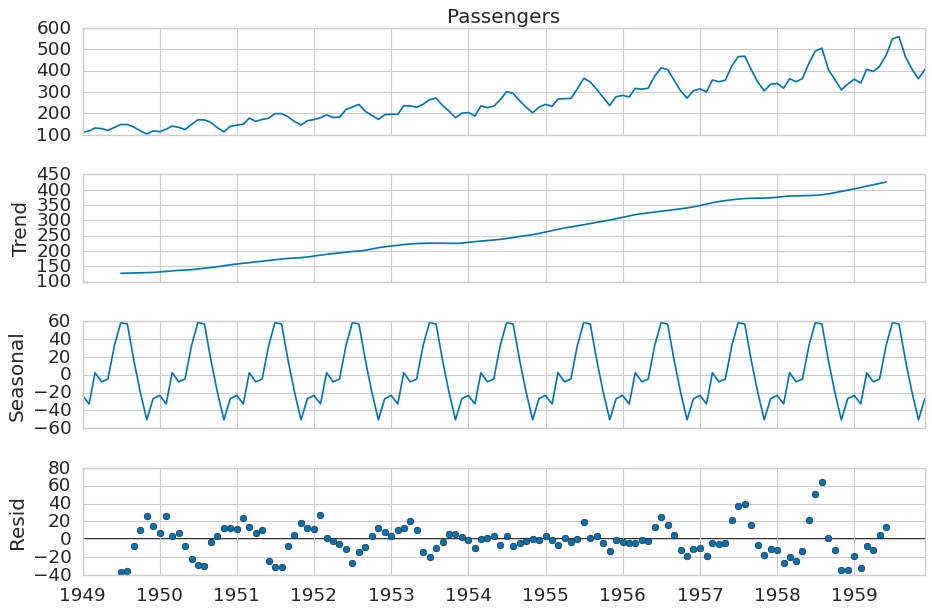

In [253]:
# additive
passengers_decomp_a = sm.tsa.seasonal_decompose(passengers, period=12, model="a")
with plt.style.context(PLOT_STYLE):
    fig = passengers_decomp_a.plot()
    fig.set_size_inches(12, 8)
    fig.tight_layout()

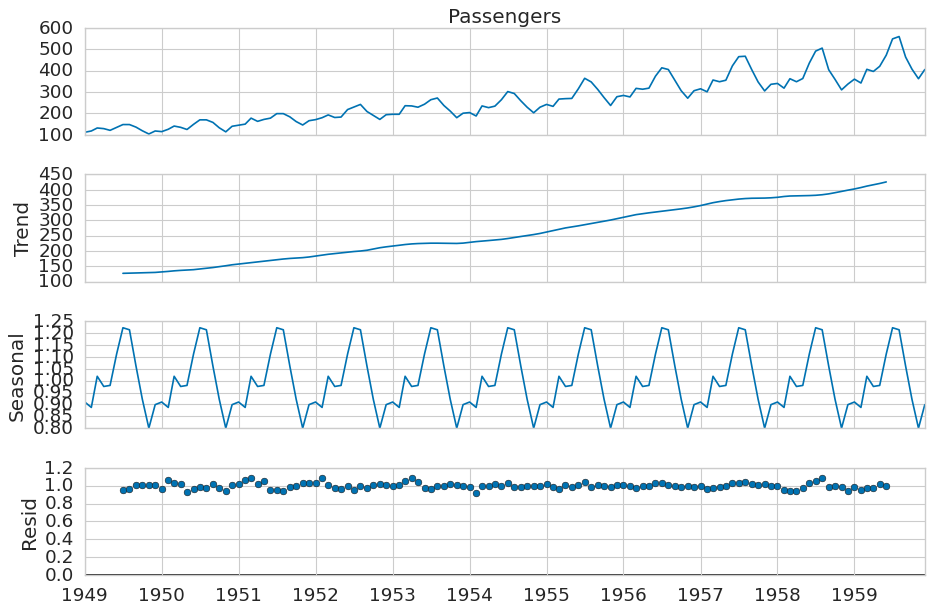

In [254]:
# multiplicative
passengers_decomp = sm.tsa.seasonal_decompose(passengers, period=12, model="m")
with plt.style.context(PLOT_STYLE):
    fig = passengers_decomp.plot()
    fig.set_size_inches(12, 8)
    fig.tight_layout()

The residuals appear reasonably constant around 1, and the trend and seasonality fits are quite predictive of the actual time series.

### Log of Passengers

The logarithm of the passengers can be decomposed _additively_, giving an alternative to the multiplicative decomposition above.

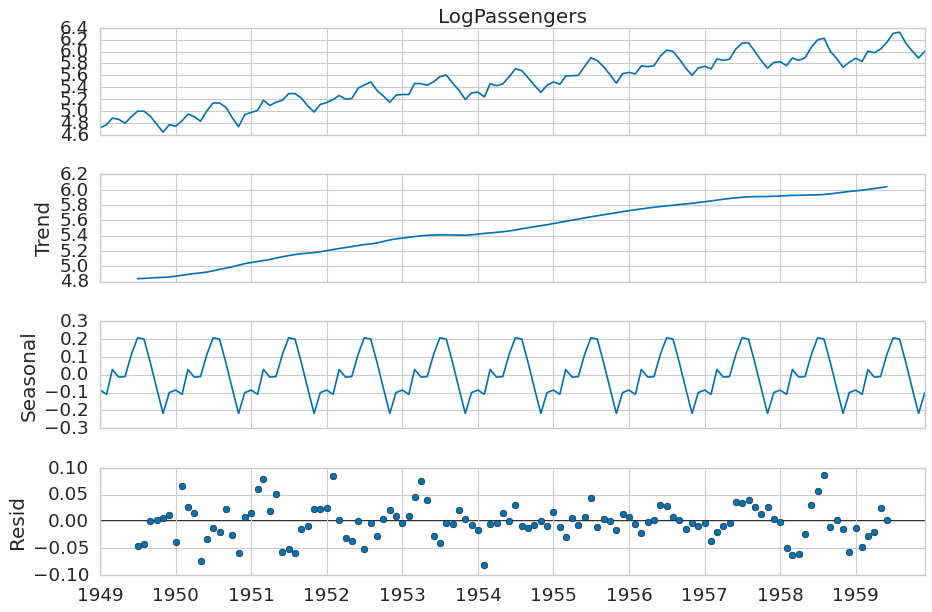

In [255]:
log_passengers_decomp = sm.tsa.seasonal_decompose(
    log_passengers, period=12, model="a")
with plt.style.context(PLOT_STYLE):
    fig = log_passengers_decomp.plot()
    fig.set_size_inches(12, 8)
    fig.tight_layout()

The multiplicative decomposition of #passengers and the additive decomposition of log(#passengers) yield very similar results, when the latter is exponentiated back.
Mathematically, this isn't always the case, as the former fits a local arithmetic mean for its trend while the latter fits a local geometric mean. Yet, in practice, the two values often overlap, leading to similar-looking residuals.

**Exercise:** compare the residuals of the two decompositions.

### Prices and Log-Returns of a Stock

First we try an additive decomposition of the stock prices. A multiplcative decomposition is also possible.


Here we don't have a clear seasonality pattern, so we try using the equivalent of a month.

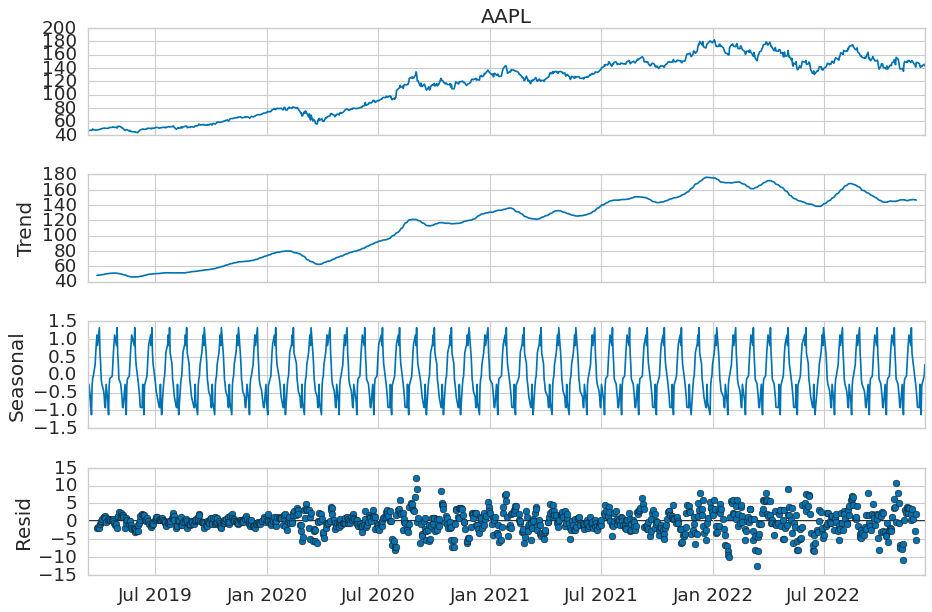

In [256]:
prices_decomp = sm.tsa.seasonal_decompose(prices, period=20, model="a")
with plt.style.context(PLOT_STYLE):
    fig = prices_decomp.plot()
    fig.set_size_inches(12, 8)
    fig.tight_layout()

The residuals have highly varying levels of residuals across time.

We can also apply the additive decomposition to the log-returns of a stock.

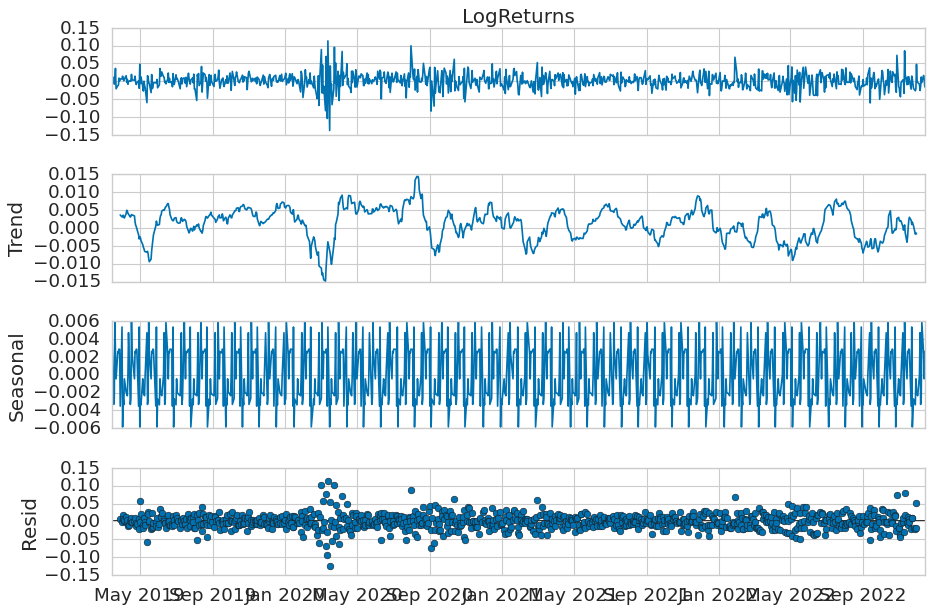

In [257]:
log_returns_decomp = sm.tsa.seasonal_decompose(log_returns, period=20, model="a")
with plt.style.context(PLOT_STYLE):
    fig = log_returns_decomp.plot()
    fig.set_size_inches(12, 8)
    fig.tight_layout()

The trend fit is not as good as in the passengers data, and now the size of the residuals appear to cluster around specific periods. This is characteristic of financial time series (specifically daily stock prices).

If we can only use models assuming constant noise, then we may want to use the weekly log-returns instead.
This gives us "smoother" residuals with less volatility clustering.

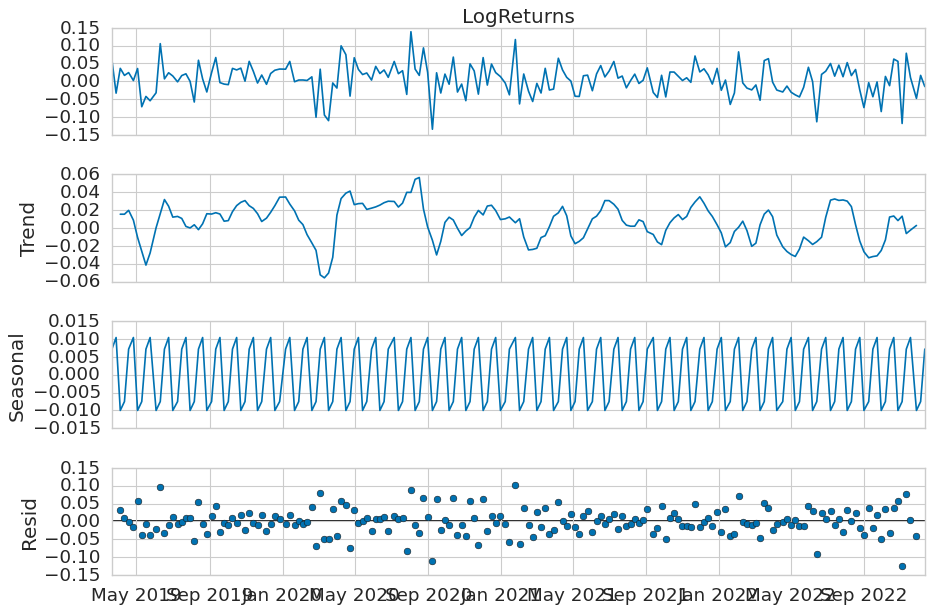

In [258]:
log_returns_5day_decomp = sm.tsa.seasonal_decompose(
    log_returns_5day, period=4, model="a")
with plt.style.context(PLOT_STYLE):
    fig = log_returns_5day_decomp.plot()
    fig.set_size_inches(12, 8)
    fig.tight_layout()

---

## Basic Trend Fitting Methods

How do we model the **trend** component of the time series?

Ideally, the trend component will model the overall increasing/decreasing patterns of the time series,
leaving us with the seasonal component (if there is one) and a white noise process.

There are many statistical methods known for fitting the trend component;
the task is often referred to as as _trend fitting_, _filtering_, or _smoothing_.

In this notebook, we cover some of the basic methods readily available in `statsmodels`.
In part II (and in HW2), we cover a general alternative approach known as _model-free prediction_.

Here, we cover three basic trend fitting methods:
1. **(Convolutional) filtering**: the default method in `seasonal_decompose()`.
2. **Exponential smoothing**: a simple and intuitive alternative.
3. **Univariate local polynomial regression ("loess")**: a nonparametric smoothing method that models the time series as a function of time.

### Filtering

Convolutional filtering is the default method for trend fitting in the `seasonal_decompose()` method we used in the previous section.
The trend fit of a (two-sided) convolutional filter is simply a weighted average of the nearby values in the time series:
$$
\hat{T}_t = \sum_{t=-s}^s a_t X_t,
$$
where $s \in \mathbb{N}$ is a pre-determined _window size_.
The sum is taken over $2s+1$ data points.

If, for simplicity, we set $a_t = \frac{1}{2s+1}$ for $t \in \{-s, \dotsc, -1, 0, 1, \dotsc, s\}$, then we simply have the moving average:
$$
\hat{T}_t = \frac{1}{2s+1} \sum_{t=-s}^s X_t.
$$

Note that this filter uses both sides (past and future) of the time series to compute the average.
For _predictive_ modeling, i.e., forecasting the future values (to be discussed soon), we may prefer a version that only uses the past values.
In `statsmodels`, this is implemented in [`convolution_filter(nsides=1)`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.filtertools.convolution_filter.html).

We also note that some advanced filtering methods are implemented as an API in `statsmodels`.
See [here](https://www.statsmodels.org/devel/examples/notebooks/generated/tsa_filters.html) for more details.

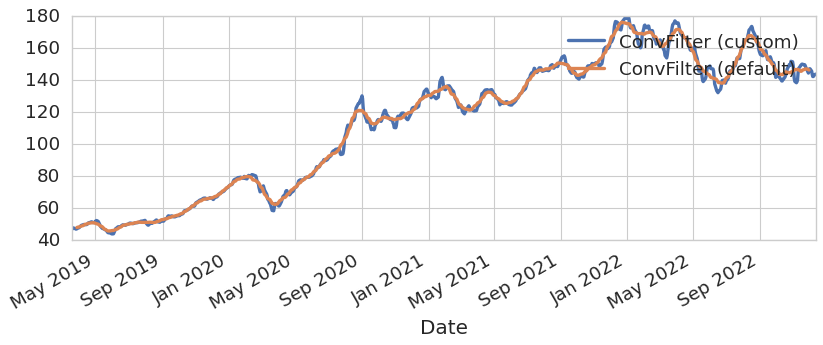

In [259]:
filt = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
filtered_prices = tsa.filters.convolution_filter(prices, filt, nsides=2)

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
filtered_prices.plot(ax=ax, linewidth=3, label="ConvFilter (custom)")
prices_decomp.trend.plot(ax=ax, linewidth=3, label="ConvFilter (default)")
ax.legend()
None

### Exponential Smoothing

A simple alternative for trend fitting is exponential smoothing.
Given a time series $(X_t)_{t\geq 0}$, we define the **$\alpha$-exponential smoother** as follows:
$$
\hat{T}_t = \sum_{j=0}^\infty \alpha(1-\alpha)^j X_{t-j},
$$
for some $\alpha \in (0, 1)$.
This also yields the following formula for iteratively updating the fit:
$$
\hat{T}_t = \alpha X_t + (1-\alpha) \hat{T}_{t-1}.
$$

Instead of looking at a fixed window around the time point $t$, an exponential smoother averages over all previous data points,
but gives an exponentially higher weight to the more recent data points.
As shown above, the hyperparameter $\alpha$ controls how much we weigh the previous point as opposed to the weighted average of all previous points.
*Thus, smaller values of $\alpha$ lead to more smoothing.*

Because exponential smoothers are _not_ forward-looking, they can also be useful in producing quick, short-term forecasts.


`statsmodels` contains a number of smoothing methods with [examples](https://www.statsmodels.org/devel/examples/notebooks/generated/exponential_smoothing.html); we adapt one of their examples to the airline passengers dataset here.

In [260]:
ses_fit = sm.tsa.ExponentialSmoothing(
    prices,
    initialization_method="heuristic",
    # could also directly add these options for a trend+seasonality fit
    # trend="add",
    # seasonal="add",
    # seasonal_periods=12,
).fit(smoothing_level=0.5)
ses_fit.summary()

Dep. Variable:,AAPL,No. Observations:,948
Model:,ExponentialSmoothing,SSE,7247.840
Optimized:,False,AIC,1932.331
Trend:,None,BIC,1942.040
Seasonal:,None,AICC,1932.373
Seasonal Periods:,None,Date:,"Mon, 17 Mar 2025"
Box-Cox:,False,Time:,14:19:02
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,46.472167,l.0,False


In [261]:
def plot_ses(xs: pd.Series, n_forecasts: int = 12):
    """Plot three simple exponential smoothers with different hyperparameters.

    Adapted from:
        https://www.statsmodels.org/devel/examples/notebooks/generated/exponential_smoothing.html
    """
    # remove index if no inferred_freq
    if xs.index.freq is None and xs.index.inferred_freq is None:
        data = xs.reset_index(drop=True)
    else:
        data = xs

    fit1 = sm.tsa.SimpleExpSmoothing(data, initialization_method="heuristic").fit(
        smoothing_level=0.2, optimized=False
    )
    fcast1 = fit1.forecast(n_forecasts).rename(r"$\alpha=0.2$")
    fit2 = sm.tsa.SimpleExpSmoothing(data, initialization_method="heuristic").fit(
        smoothing_level=0.6, optimized=False
    )
    fcast2 = fit2.forecast(n_forecasts).rename(r"$\alpha=0.6$")
    fit3 = sm.tsa.SimpleExpSmoothing(data, initialization_method="estimated").fit()
    fcast3 = fit3.forecast(n_forecasts).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

    plt.figure(figsize=FIGSIZE)
    (data, ) = plt.plot(data, ".-", color="gray", alpha=0.7, linewidth=2)
    (line1, ) = plt.plot(pd.concat([fit1.fittedvalues, fcast1], axis=0), ".-", alpha=0.9, linewidth=2)
    (line2, ) = plt.plot(pd.concat([fit2.fittedvalues, fcast2], axis=0), ".-", alpha=0.9, linewidth=2)
    (line3, ) = plt.plot(pd.concat([fit3.fittedvalues, fcast3], axis=0), ".-", alpha=0.9, linewidth=2)
    plt.legend([data, line1, line2, line3], ["Data", fcast1.name, fcast2.name, fcast3.name])

In the below, the last 12 steps are _forecast_ values from the exponential smoother.

Overall, we can see that the smoothing level $\alpha$ determines how much smoothing you want to enforce.

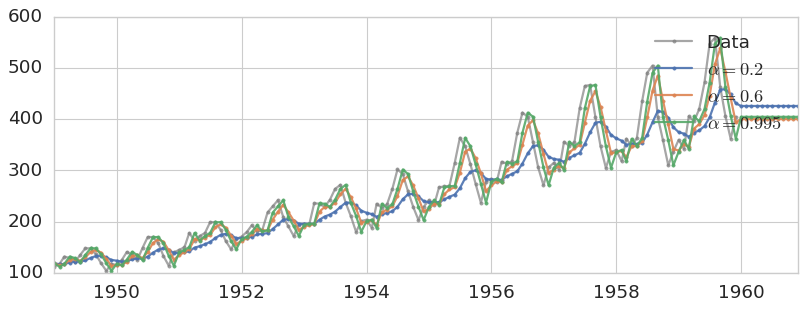

In [262]:
plot_ses(passengers)

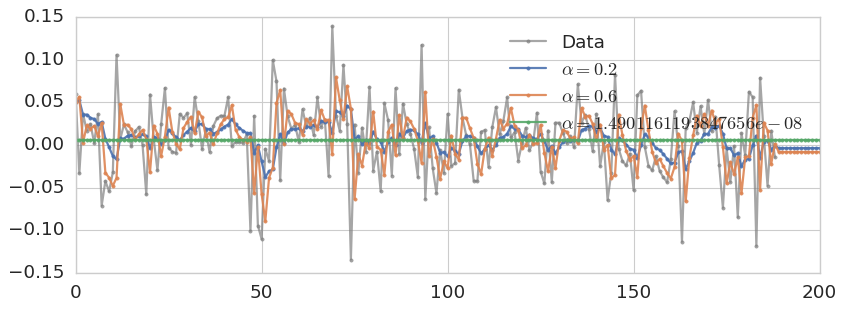

In [263]:
plot_ses(log_returns_5day)

Depending on the value of $\alpha$ (smaller values meaning more smoothing), even the simple exponential smoother seems to capture the trend quite well in either case.
Obviously, it only produces one value of "forecast" for future predictions, so for forecasting purposes one may want to use other methods (see, e.g., [here](https://www.statsmodels.org/devel/tsa.html#exponential-smoothing)).



### Univariate Local Linear Regression

We will cover local linear (kernel) regression in a lot more detail in Part II, but for now we simply think of it as an alternative approach to curve fitting/smoothing.
While the previous methods implement simple local weighted averaging with heuristically chosen weights, a kernel regressor performs local weighted averaging with _data-dependent_ weights (closer data points are given higher weights).

The [STL method](https://www.wessa.net/download/stl.pdf) performs a seasonal decomposition by fitting a loess smoother for the trend component. `statsmodels` has an implementation of the method [`STL`](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html), along with a forecasting API given by `STLForecast`.
Here we focus on its trend fitting capacity.

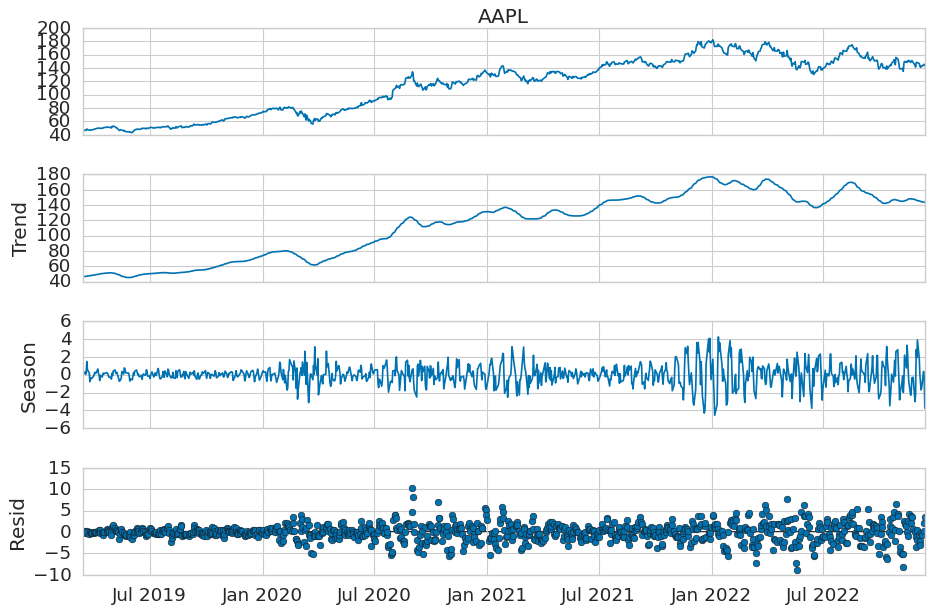

In [264]:
stl_fit = tsa.STL(prices, period=12).fit()
with plt.style.context(PLOT_STYLE):
    fig = stl_fit.plot()
    fig.set_size_inches(12, 8)
    fig.tight_layout()

We can now compare the three different trend fitting methods introduced in this notebook.

It is important to note that, with any of these methods, one can control the level of smoothing as desired.
Here, we choose the levels that make each fit roughly similar in terms of smoothness.

In [265]:
convfilter_fit = sm.tsa.seasonal_decompose(
    prices, period=5, model="a", two_sided=False,
).trend
ses_fit = sm.tsa.ExponentialSmoothing(
    prices,
    initialization_method="heuristic",
).fit(smoothing_level=0.5)

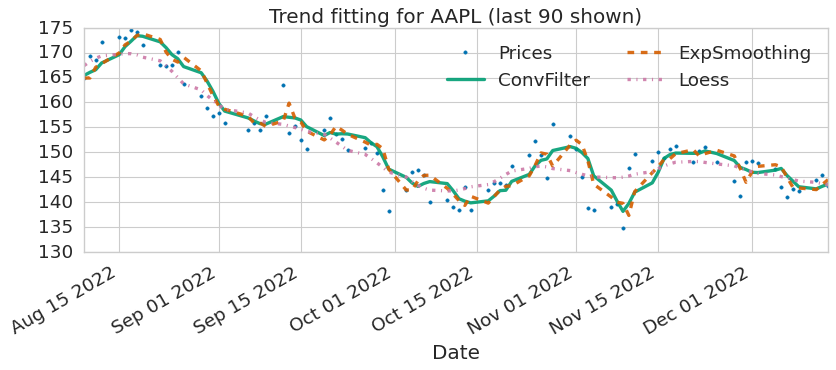

In [266]:
n_days = 90
with plt.style.context(PLOT_STYLE):
    fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    prices[-n_days:].plot(ax=ax, label="Prices", style=".")
    convfilter_fit[-n_days:].plot(
        ax=ax, label="ConvFilter",
        linewidth=3, linestyle="solid", alpha=0.9,
    )
    ses_fit.fittedvalues[-n_days:].plot(
        ax=ax, label="ExpSmoothing",
        linewidth=3, linestyle="dashed", alpha=0.9,
    )
    stl_fit.trend[-n_days:].plot(
        ax=ax, label="Loess",
        linewidth=3, linestyle="dashdot", alpha=0.9,
    )
    ax.set_title(f"Trend fitting for {SYMBOL} (last {n_days} shown)")
    ax.legend(ncol=2)

## Tests for White Noise

In previous classes, we discussed some of the formal tests for checking whether the noise process is a white noise, including the Bartlett's formula for testing autocorrelation at specified lags and the Ljung-Box and Box-Pierce tests for simultaneously testing autocorrelations at all lags.

**Note:** The confidence bands provided in the autocorrelation plots above, via [`tsa.graphics.plot_acf()`](https://www.statsmodels.org/devel/generated/statsmodels.graphics.tsaplots.plot_acf.html), use the Bartlett's formula at 95% coverage level.
This implies that, if we look at 20 lags, we expect to see one (5%) "false positive" autocorrelation.

The Ljung-Box and Box-Pierce tests get around this issue. These are part of homework 2, so we will not cover them here.

---

## Up Next

- In part II of the tutorial, we will discuss using nonparametric regression methods to estimate the trend _and_ the noise without making parametric model assumptions ("model-free").
- In part III of the tutorial, we will return to modeling the _noise_ component of the time series, assuming that it is stationary. This will give a model-based approach to modeling and forecasting financial time series.